# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "ana1000s3_long"   # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 100

##########################################################################



import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(5602, 32, 32, 3)
(5602, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [3]:
inputs = tf.keras.Input(shape=(32, 32, 3))
inputs2 = tf.keras.layers.BatchNormalization()(inputs)
inputs3 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation="relu")(inputs2)
inputs4 = tf.keras.layers.MaxPool2D(pool_size=(4,4))(inputs3)
inputs5 = tf.keras.layers.Conv2D(16, (5, 5), padding='same', activation="relu")(inputs4)
inputs6 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs5)
inputs7 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu")(inputs6)
inputs8 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs7)
inputs9 = tf.keras.layers.Flatten()(inputs8)
inputs10 = tf.keras.layers.Dense(64,activation="relu")(inputs9)
inputs11 = tf.keras.layers.Dense(32,activation="relu")(inputs10)
output = tf.keras.layers.Dense(2)(inputs11)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

model.summary()

#model = Sequential()
#model.add(BatchNormalization(input_shape=(32,32,3)))
#model.add(Conv2D(32, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(4,4)))
#model.add(Conv2D(16, (5, 5), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(4,4)))
#model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Flatten())
#model.add(Dense(64,activation="relu"))
#model.add(Dense(32,activation="relu"))
#model.add(Dense(2))
#model.summary()

#model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          12816     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 16)         0     

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [4]:
Batch_Size = 8
Epoch_Anz = 30
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



C:\Users\Muell\AppData\Local\Temp\ipykernel_24868\3831122756.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)


Epoch 1/30
701/701 [==============================] - 47s 41ms/step - loss: 0.1585 - accuracy: 0.8577 - val_loss: 0.0203 - val_accuracy: 0.9697
Epoch 2/30
701/701 [==============================] - 20s 28ms/step - loss: 0.0267 - accuracy: 0.9634 - val_loss: 0.0163 - val_accuracy: 0.9652
Epoch 3/30
701/701 [==============================] - 20s 28ms/step - loss: 0.0141 - accuracy: 0.9720 - val_loss: 0.0092 - val_accuracy: 0.9741
Epoch 4/30
701/701 [==============================] - 21s 30ms/step - loss: 0.0090 - accuracy: 0.9766 - val_loss: 0.0048 - val_accuracy: 0.9839
Epoch 5/30
701/701 [==============================] - 20s 28ms/step - loss: 0.0063 - accuracy: 0.9772 - val_loss: 0.0040 - val_accuracy: 0.9848
Epoch 6/30
701/701 [==============================] - 21s 29ms/step - loss: 0.0048 - accuracy: 0.9829 - val_loss: 0.0035 - val_accuracy: 0.9857
Epoch 7/30
701/701 [==============================] - 20s 28ms/step - loss: 0.0039 - accuracy: 0.9838 - val_loss: 0.0030 - val_accuracy:

### Step 1: Learing result
 
* Visualization of the training and validation results

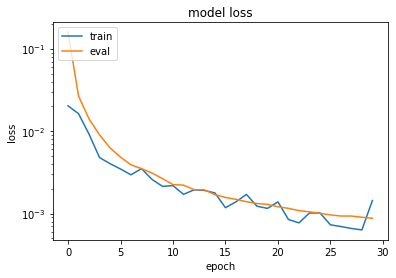

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)

plt.semilogy(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [6]:
Batch_Size = 8
Epoch_Anz = 160
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)


C:\Users\Muell\AppData\Local\Temp\ipykernel_24868\1492021130.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)


Epoch 1/160
701/701 [==============================] - 20s 28ms/step - loss: 0.0536 - accuracy: 0.9348 - val_loss: 0.0112 - val_accuracy: 0.9786
Epoch 2/160
701/701 [==============================] - 23s 32ms/step - loss: 0.0139 - accuracy: 0.9718 - val_loss: 0.0069 - val_accuracy: 0.9848
Epoch 3/160
701/701 [==============================] - 22s 31ms/step - loss: 0.0093 - accuracy: 0.9763 - val_loss: 0.0054 - val_accuracy: 0.9795
Epoch 4/160
701/701 [==============================] - 23s 33ms/step - loss: 0.0060 - accuracy: 0.9777 - val_loss: 0.0048 - val_accuracy: 0.9848
Epoch 5/160
701/701 [==============================] - 23s 33ms/step - loss: 0.0050 - accuracy: 0.9786 - val_loss: 0.0043 - val_accuracy: 0.9822
Epoch 6/160
701/701 [==============================] - 22s 32ms/step - loss: 0.0042 - accuracy: 0.9821 - val_loss: 0.0031 - val_accuracy: 0.9866
Epoch 7/160
701/701 [==============================] - 24s 34ms/step - loss: 0.0038 - accuracy: 0.9836 - val_loss: 0.0027 - val_ac

701/701 [==============================] - 22s 32ms/step - loss: 0.0010 - accuracy: 0.9907 - val_loss: 7.6577e-04 - val_accuracy: 0.9929
Epoch 68/160
701/701 [==============================] - 21s 30ms/step - loss: 8.9115e-04 - accuracy: 0.9918 - val_loss: 7.9243e-04 - val_accuracy: 0.9946
Epoch 69/160
701/701 [==============================] - 22s 31ms/step - loss: 9.4547e-04 - accuracy: 0.9911 - val_loss: 6.9203e-04 - val_accuracy: 0.9946
Epoch 70/160
701/701 [==============================] - 21s 30ms/step - loss: 8.6512e-04 - accuracy: 0.9914 - val_loss: 6.6129e-04 - val_accuracy: 0.9964
Epoch 71/160
701/701 [==============================] - 22s 31ms/step - loss: 9.4121e-04 - accuracy: 0.9925 - val_loss: 7.3147e-04 - val_accuracy: 0.9920
Epoch 72/160
701/701 [==============================] - 22s 31ms/step - loss: 8.2781e-04 - accuracy: 0.9913 - val_loss: 8.1104e-04 - val_accuracy: 0.9938
Epoch 82/160
701/701 [==============================] - 22s 32ms/step - loss: 8.1107e-04 - ac

701/701 [==============================] - 23s 32ms/step - loss: 5.8326e-04 - accuracy: 0.9939 - val_loss: 4.8999e-04 - val_accuracy: 0.9929
Epoch 155/160
701/701 [==============================] - 22s 31ms/step - loss: 5.6761e-04 - accuracy: 0.9945 - val_loss: 5.1414e-04 - val_accuracy: 0.9920
Epoch 156/160
701/701 [==============================] - 21s 30ms/step - loss: 5.9726e-04 - accuracy: 0.9954 - val_loss: 4.8775e-04 - val_accuracy: 0.9964
Epoch 159/160
701/701 [==============================] - 23s 32ms/step - loss: 5.8235e-04 - accuracy: 0.9948 - val_loss: 4.9006e-04 - val_accuracy: 0.9955
Epoch 160/160
701/701 [==============================] - 22s 31ms/step - loss: 5.8853e-04 - accuracy: 0.9948 - val_loss: 6.1248e-04 - val_accuracy: 0.9964


### Overall Learing results (Step 1 & Step 2)

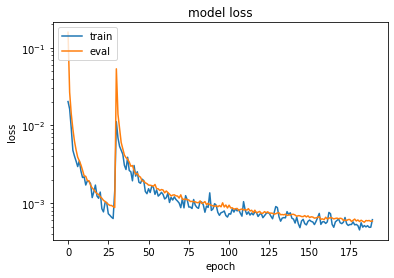

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])


if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [8]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
stat_Anz = []
stat_Abweichung = []
i = 0
deviation_max_list = 0.05

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for aktfile in files:
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
            
    target_int = int ((float(base[0:3])) * 10)
    stat_Abweichung[target_int] = stat_Abweichung[target_int] + dev_target  
    stat_Anz[target_int] = stat_Anz[target_int] + 1
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    if abs(dev_target) > deviation_max_list:
        print(aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target))

    
for i in range(100):
    stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res

1/1 [==============================] - 0s 288ms/step
data_resize_all\0.0_0023_zeiger3_2020-04-29_11-55-02.jpg 0.0 0.07131914673872834 -0.07131914673872834
1/1 [==============================] - 0s 285ms/step
data_resize_all\0.0_0071_zeiger3_2020-04-29_12-47-02.jpg 0.0 0.06522887101286569 -0.06522887101286569
1/1 [==============================] - 0s 168ms/step
data_resize_all\0.1_0071_zeiger3_2020-04-29_12-47-02.jpg 0.01 0.06522887101286569 -0.055228871012865687
1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 151ms/step
data_resize_all\0.3_0149_zeiger3_2020-04-29_12-06-02.jpg 0.03 0.0881288209549344 -0.05812882095493441
1/1 [==============================] - 0s 94ms/step
data_resize_all\0.5_0213_zeiger4_2020-04-29_13-45-02.jpg 0.05 0.13289282778770092 -0.08289282778770092
1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 49ms/step
data_resize_all\0.7_0257_zeiger4_2020-04-29_10-58-40.jpg 0.06999999999999999 0.17430213977774645 -0.10430213977774645
1/1 [==============================] - 0s 196ms/step
data_resize_all\0.8_0276_zeiger2_2019-06-03T221010.jpg 0.08 0.15420206936075598 -0.07420206936075598
1/1 [==============================] - 0s 174ms/step
data_resize_all\0.8_0277_zeiger2_2019-06-04T014009.jpg 0.08 0.13764895412524852 -0.05764895412524852
1/1 [==============================] - 0s 93ms/step
data_resize_all\0.9_0325_zeiger2_2019-06-03T222009.jpg 0.09 0.15528124873599183 -0.06528124873599184
1/1 [==============================] - 0s 91ms/step
data_resize_all\0.9_0327_zeiger2_2019-06-03T224009.jpg 0.09 0.1531233073859694 -0.06312330738596941
1/1 [==============================] - 0s 95ms/step
data_resize_all\0.9_0328_zeiger2_2019-06-03T225009.jpg 0.09 0.22140712754391792 -0.13140712754391792


1/1 [==============================] - 0s 77ms/step
data_resize_all\0.9_0335_zeiger2_2019-06-04T000009.jpg 0.09 0.1496303106989295 -0.05963031069892949
1/1 [==============================] - 0s 129ms/step
data_resize_all\0.9_0337_zeiger2_2019-06-04T002009.jpg 0.09 0.15644526475254358 -0.06644526475254359
1/1 [==============================] - 0s 109ms/step
data_resize_all\0.9_0339_zeiger2_2019-06-04T004009.jpg 0.09 0.1433852979860576 -0.053385297986057595
1/1 [==============================] - 0s 95ms/step
data_resize_all\0.9_0347_zeiger2_2019-06-04T021009.jpg 0.09 0.1425978151202505 -0.052597815120250496
1/1 [==============================] - 0s 106ms/step
data_resize_all\0.9_0350_zeiger2_2019-06-04T171009.jpg 0.09 0.15311257829714817 -0.06311257829714817
1/1 [==============================] - 0s 161ms/step
data_resize_all\0.9_0352_zeiger2_2019-06-04T173009.jpg 0.09 0.1492121987716124 -0.059212198771612407
1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 90ms/step
data_resize_all\1.8_ana4_20220629-153729.jpg 0.18 0.07279763130512915 0.10720236869487085
1/1 [==============================] - 0s 127ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 40ms/step
data_resize_all\4.7_2398_zeiger4_2019-06-02T053013.jpg 0.47000000000000003 0.4158432799842803 0.05415672001571975
1/1 [==============================] - 0s 43ms/step
data_resize_all\4.7_2399_zeiger4_2019-06-02T163009.jpg 0.47000000000000003 0.4149561143020864 0.05504388569791363
1/1 [==============================] - 0s 36ms/step
data_resize_all\4.8_2436_zeiger3_2020-04-29_12-23-02.jpg 0.48 0.42406709336344334 0.055932906636556645
1/1 [==============================] - 0s 43ms/step
data_resize_all\5.0_2493_zeiger3_2020-04-29_12-41-02.jpg 0.5 0.4485825016238932 0.05141749837610682
1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 44ms/step
data_resize_all\5.0_2516_zeiger3_2020-04-29_12-30-02.jpg 0.5 0.444932903877383 0.05506709612261701
1/1 [==============================] - 0s 44ms/step
data_resize_all\5.0_2520_zeiger4_2019-06-04T141009.jpg 0.5 0.43023137703487524 0.06976862296512476
1/1 [==============================] - 0s 37ms/step
data_resize_all\5.1_2583_zeiger4_2019-06-02T110009.jpg 0.51 0.4292959067370512 0.0807040932629488
1/1 [==============================] - 0s 41ms/step
data_resize_all\5.2_2608_zeiger4_2019-06-02T180009.jpg 0.52 0.44785910869979806 0.07214089130020196
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 33ms/step
data_resize_all\5.4_2691_zeiger4_2019-06-02T202009.jpg 0.54 0.479566478483299 0.06043352151670106
1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 32ms/step
data_resize_all\5.6_2759_zeiger3_2020-04-29_11-54-02.jpg 0.5599999999999999 0.4978924831543694 0.06210751684563054
1/1 [==============================] - 0s 43ms/step
data_resize_all\5.8_2836_zeiger3_2020-04-29_13-23-01.jpg 0.58 0.5226299206263002 0.057370079373699756
1/1 [==============================] - 0s 39ms/step
data_resize_all\5.8_2847_zeiger4_2020-04-29_14-07-02.jpg 0.58 0.5203780831479378 0.059621916852062196
1/1 [==============================] - 0s 43ms/step
data_resize_all\5.9_2864_zeiger1_2020-04-29_14-22-02.jpg 0.5900000000000001 0.5395988046547845 0.05040119534521559
1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 38ms/step
data_resize_all\5.9_2889_zeiger4_2020-04-29_11-43-02.jpg 0.5900000000000001 0.5394847784411407 0.05051522155885935
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step
data_resize_all\7.6_pointer_20211011-123542.jpg 0.76 0.8114866460984143 -0.051486646098414246
1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 40ms/step
data_resize_all\9.4_pointer_20211020-152609.jpg 0.9400000000000001 0.9946593250846806 -0.05465932508468052
1/1 [==============================] - 0s 39ms/step
data_resize_all\9.4_pointer_20211021-065817.jpg 0.9400000000000001 0.9979646437962004 -0.057964643796200366
1/1 [==============================] - 0s 49ms/step
data_resize_all\9.6.jpg 0.96 0.8940053014510817 0.06599469854891826
1/1 [==============================] - 0s 53ms/step
data_resize_all\9.6_4753_zeiger2_2020-04-29_12-54-02.jpg 0.96 1.0207254311537481 -0.06072543115374818
1/1 [==============================] - 0s 41ms/step
data_resize_all\9.6_4796_zeiger2_2020-04-29_12-46-02.jpg 0.96 1.047425015331095 -0.08742501533109515
1/1 [==============================] - 0s 47ms/step
data_resize_all\9.6_4802_zeiger4_2020-04-29_11-34-02.jpg 0.96 1.0564439338774514 -0.09644393387745143
1/1 [==============================] - 0s 47ms/step
data_resize_all\9.6_4803_zeiger4_2020-04-29_11-5

1/1 [==============================] - 0s 36ms/step
data_resize_all\9.6_PRODUCED_ANALOG_2.jpg 0.96 0.8861596623653388 0.07384033763466114
1/1 [==============================] - 0s 23ms/step
data_resize_all\9.8_4853_zeiger4_2020-04-29_11-19-02.jpg 0.9800000000000001 1.0550534544012315 -0.07505345440123146
1/1 [==============================] - 0s 38ms/step
data_resize_all\9.8_4928_zeiger2_2020-04-29_12-15-02.jpg 0.9800000000000001 1.0564631959595483 -0.0764631959595482
1/1 [==============================] - 0s 36ms/step
data_resize_all\9.8_4932_zeiger3_2020-04-29_14-00-02.jpg 0.9800000000000001 1.032509791316524 -0.05250979131652389
1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 26ms/step
data_resize_all\9.9_5003_zeiger4_2020-04-29_12-57-02.jpg 0.99 1.047391428824489 -0.057391428824489
1/1 [==============================] - 0s 42ms/step


## Results

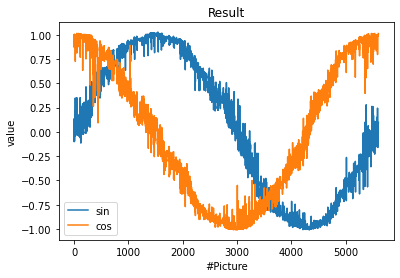

In [9]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

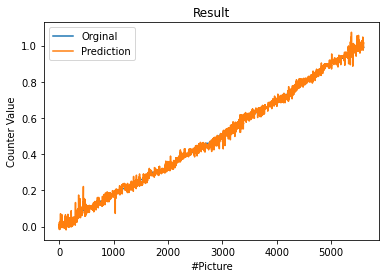

In [10]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

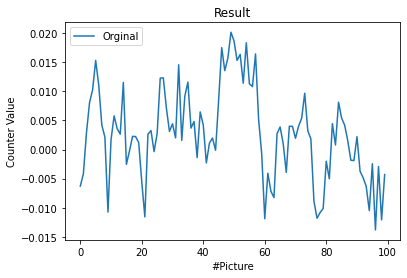

In [11]:
plt.plot(stat_Abweichung)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

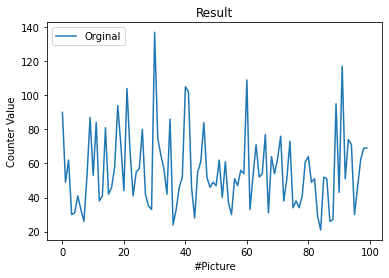

In [12]:
plt.plot(stat_Anz)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

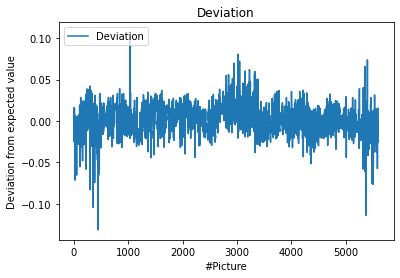

[ 0.0021  0.016  -0.1314  0.1072]


In [13]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [14]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpzjy0uj_2\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpzjy0uj_2\assets


125772

In [15]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()


open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpiyhvigoh\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpiyhvigoh\assets
C:\Users\Muell\anaconda3\envs\py39-tf-opencv\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


38544